This jupyter notebook contains basic blocks which creates obs .noos files and correct xml files for the openda models

In [1]:
import numpy as np
import os
import datetime
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon
import copy
import shutil
import pandas as pd
import matplotlib.cm as mcmap
from lxml import etree


The first step is getting observations and having a correct xml file for the same. Now, idea is to have a polygon which say, defines ice cover. And in this polygon which tide gauges do I have. Normally, we should consider all the TG. But for now, we keep it simple and just consider a few of the TG. It is for test and we would then see how can it be made better. 

In [2]:
#Definition of parameters
#polygon parameters
lon1=-99.0;lon2=-77.0
lat1=50.0;lat2=64.0
coords=[(lon1, lat1), (lon1,lat2), (lon2,lat2), (lon2, lat1),(lon1, lat1)]
poly = Polygon(coords)
print(poly)
#the above polygon is not needed for general simulation with all TG. 
#tg data location. and reading. 
datafolder='CHSdata'
# tstafile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/bathymetry_checks/CHSTG.xyn'  #file of all the TG stations in the regional model domain.
tstafile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/bathymetry_checks/CHSTG_snapped_model_obs.xyn' #file which has obs on wet cells in canada model.
tstanamfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/bathymetry_checks/CHSTG.xyn'
tgfileloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/bathymetry_checks/CHSdata/'
# newtgfileloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Observations/CHSTG/March_Hudsonbay/'
newtgfileloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Observations/CHSTG/Sept_All/'
monthdict={'Jan':'01', 'Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
            'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
month='Sep'
sdate='202003010000'
edate='202004010000'
headerlist=["Lon","Lat","Name"]
df=pd.read_csv(tstafile,delim_whitespace=True,names=headerlist,quotechar="'")
tstaposdata=np.vstack((df['Lon'],df['Lat'])).T
# dfnam=pd.read_csv(tstanamfile,delim_whitespace=True,names=headerlist,quotechar="'")

tstanamdata=np.array(df['Name'])
# tstanamdata=np.where(tstanamdata=='Frobisher',"Frobisher's Farthest",tstanamdata)
# tstanamsnapdata=np.array(df['Name'])
# tstaposdata=np.loadtxt(tstafile,usecols=(0,1),dtype='float')
# tstanamdata=np.loadtxt(tstafile,usecols=(2),dtype='str',delimiter='\t')

POLYGON ((-99 50, -99 64, -77 64, -77 50, -99 50))


Getting the observations of tide gauges. We start by getting the TG in the domain of the polygon which defines our parameters.

In [3]:
#getting TG in this domain.
# selTGpos=[];selTGnam=[]
# lonvec=[];latvec=[]
# for i in range(len(tstanamdata)):
#     loni=tstaposdata[i,0]
#     lati=tstaposdata[i,1]
#     if -99.0<=loni<=-77.0 and 50.0<=lati<=64.0:
#         selTGnam=np.append(selTGnam,tstanamdata[i])
#         lonvec=np.append(lonvec,loni)
#         latvec=np.append(latvec,lati)
# selTGpos=np.vstack((lonvec,latvec)).T
# we remove certain TG as they are not helpful in cf optimization. the ouput at these locations 
#is not correct from model.
#The above is used to find tg in a particular domain,
rindex=np.array([121,128,49,31]).astype(int)

#now we add more TG because of them lying in fiords etc.
indexarray=np.array([44,124,88,111,19,133,54,78,22,73,77,99,66,46,30,98,23,92,74,33,47,105,122,153,123,134,140,131,144,110,141,113,29]).astype(int)
rindex=np.append(rindex,indexarray)
print(tstanamdata[rindex])
selTGpos=np.delete(tstaposdata,rindex,axis=0)
selTGnam=np.delete(tstanamdata,rindex)


['Cape Dyer' 'MOSTYN COVE' 'Stag Island' 'Innetalling Island'
 'Digges Harbour' 'Lewis Bay' 'Disreali Fiord' 'Discovery Harbour'
 'Shingle Point' 'Imigen Island' 'Purfur Cove' 'Kugaaruk' 'Cameron Island'
 'Cape Barclay' 'Cape Sibbald' 'Cape Berens' 'Lavoie Islands' 'Sand Head'
 'North Kopak Island' 'Strutton Islands' 'Akulivik' 'Hook Island'
 'Inukjuak' 'La Grande Riviere ' 'Moosonee' 'Nicholson Creek'
 'Stupart Bay' 'Doctor Island' 'JORDANS POINT' 'MAKKOVIK' 'JACKOS POINT'
 'SANDWICH BAY (EAST ARM)' 'Sorry Harbour' 'Agvik Island'
 'Kangiqsualujjuaq' 'WILLIAMS HARBOUR' 'Marble Island']


plot the tg to check if the lie in the polygon.

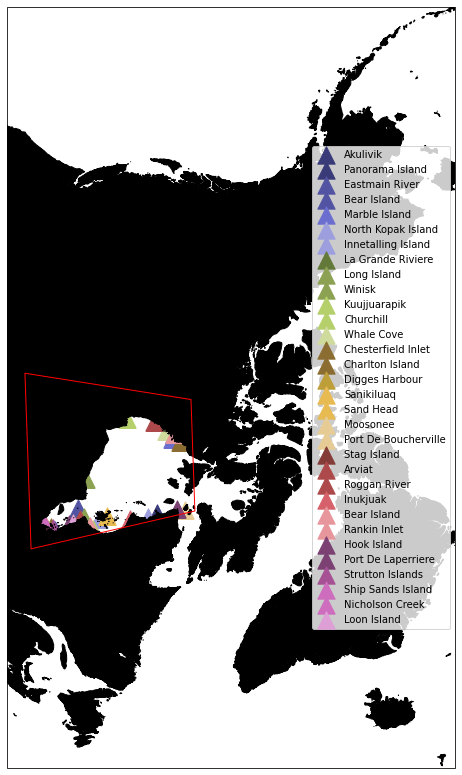

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
# cbarlabel='Difference(March-Sept)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
# cont1=ax1.scatter(selTGpos[:,0],selTGpos[:,1],c=selTGnam,transform=ccrs.PlateCarree(),marker='^',s=300)
# cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
cmap = mcmap.get_cmap('tab20b')
dc=1.0/len(selTGnam)

for i in range(len(selTGnam)):
    rgba = cmap(i*dc)
    ax1.scatter(selTGpos[i,0],selTGpos[i,1],transform=ccrs.PlateCarree(),marker='^',s=300,label=selTGnam[i],color=rgba)
ax1.legend(loc=5)    

# TGname=['Akulivik','Innetalling','Port De Lapperrier']
# Tgpos=np.array([[-78.1933,60.805],[-79.086,55.913],[-78.07,62.5634]])
# ax1.scatter(Tgpos[:,0],Tgpos[:,1],transform=ccrs.PlateCarree(),marker='^',s=300)
ax1.add_geometries([poly], crs=ccrs.PlateCarree(),  edgecolor='red', facecolor='None',alpha=1)
# cbar.set_label(cbarlabel, rotation=90, fontsize=18)
# cbar.ax.tick_params(labelsize=18)
plt.show()

In [ ]:
TGname=['Akulivik','Innetalling','Port De Lapperrier']
Tgpos=[[-78.1933,60.805],[-79.086,55.913],[-78.07,62.5634]]

The next step is to get water level data TGs for a given month.

In [8]:
 
def getmonthdata(tgfile,newtgfile,month):
    wltimdata=np.loadtxt(tgfile,skiprows=2,usecols=0,dtype='str')
    hdata=np.array(np.loadtxt(tgfile,skiprows=2,usecols=1))
    monthval=monthdict[month]
    timdata=[datetime.datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in wltimdata]
    monthvec=np.array([datetime.datetime.strftime(i,"%m") for i in timdata])
    index=np.array(np.where(monthvec==monthval))  
    index=np.append(index,index[0,-1]+1)
    # print(np.shape(index))
    # print(index)
    monthhdata=hdata[index]
    monthtimdata=wltimdata[index]
    vec=np.hstack((monthtimdata.reshape(len(monthtimdata),1),monthhdata.reshape(len(monthhdata),1)))
    f = open(tgfile, "r")
    lines = f.readlines()
    f.close()
    headstring=[]
    for line in lines[:2]:
        headstring.append(line)
    print(str(headstring))    
    np.savetxt(newtgfile,vec,fmt='%s',delimiter="\t\t",header=str(headstring[:]))

    
def convertwl2noos(tgfile,newtgfile):
    #skiprows 1 for month file and all year file it is 2.
    timdata=np.loadtxt(tgfile,skiprows=1,usecols=0,dtype='str')
    timdata=[datetime.datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in timdata]
    noostimdata=np.array([datetime.datetime.strftime(i,"%Y%m%d%H%M") for i in timdata])
    hdata=np.array(np.loadtxt(tgfile,skiprows=1,usecols=1))
    vec=np.hstack((noostimdata.reshape(len(noostimdata),1),hdata.reshape(len(hdata),1)))
    f = open(tgfile, "r")
    lines = f.readlines()
    f.close()
    headstring=[]
    for line in lines[:2]:
        headstring.append(line)
    print(str(headstring))   
    np.savetxt(newtgfile,vec,fmt='%s',delimiter="\t\t",header=str(headstring[:]))

Now get the .wl files for all the selected TG. Next convert the .wl tidegauge files from the curent format to a .noos format in which the date is changed from 2020-01-01T00:00:00Z to 202001010000

In [13]:

for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]   #[1:-1] only when using np.lodtext
    tgfile=tgfileloc+tgname+'.wl'
    newtgfile=newtgfileloc+tgname+'_'+month+'.wl'

    getmonthdata(tgfile,newtgfile,month)
    #converting to .noos file
    noostgfile=newtgfileloc+tgname+'_'+month+'.noos'
    convertwl2noos(newtgfile,noostgfile)


['# Station Name:Sachs Harbour\t Station number:67\tStation id:5cebf1de3d0f4a073c4bb9eb\n', '# Lon:-125.25\tLat:71.966667\n']
["# ['# Station Name:Sachs Harbour\\t Station number:67\\tStation id:5cebf1de3d0f4a073c4bb9eb\\n', '# Lon:-125.25\\tLat:71.966667\\n']\n", '2020-03-01T00:00:00Z\t\t0.164\n']
['# Station Name:Pearce Point\t Station number:69\tStation id:5cebf1de3d0f4a073c4bb9e3\n', '# Lon:-122.666667\tLat:69.816389\n']
["# ['# Station Name:Pearce Point\\t Station number:69\\tStation id:5cebf1de3d0f4a073c4bb9e3\\n', '# Lon:-122.666667\\tLat:69.816389\\n']\n", '2020-03-01T00:00:00Z\t\t0.345\n']
['# Station Name:Cape Parry\t Station number:71\tStation id:5cebf1de3d0f4a073c4bb9e7\n', '# Lon:-124.666667\tLat:70.15\n']
["# ['# Station Name:Cape Parry\\t Station number:71\\tStation id:5cebf1de3d0f4a073c4bb9e7\\n', '# Lon:-124.666667\\tLat:70.15\\n']\n", '2020-03-01T00:00:00Z\t\t0.284\n']
['# Station Name:Kugluktuk\t Station number:75\tStation id:5cebf1de3d0f4a073c4bb9dd\n', '# Lon:-115.

Now creating a xml file which has all the TG and correct start and end time.

In [9]:
tempxmlfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Observations/CHSTG/noosObservations_template.xml'
newxmlfile=newtgfileloc+'noosObsfile_reduced.xml'
shutil.copy2(tempxmlfile,newxmlfile)
tree=ET.parse(newxmlfile)
root=tree.getroot()
# for elem in root.iter("timeSeries"):
# dupe=copy.deepcopy(root[0])

# for i in range(len(selTGnam))[:2]:
#     # new_element = ET.SubElement(root[i], dupe.tag, dupe.attrib)
#     root.insert(i,dupe)
baseelem=root[0]
for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]     #[1:-1]
    atgname=tgname+'_'+month+'.waterlevel'
    attrib=baseelem.attrib
    attrib['minDateTime']=sdate
    attrib['maxDateTime']=edate
    attrib['id']=atgname
    textval=tgname+'_'+month+'.noos'
    
    print(atgname)
    print(textval)
    elem=root.makeelement('timeSeries', attrib)
    elem.text=textval
    root.append(elem)
root.remove(root[0])

ET.register_namespace("", "http://www.openda.org") 
# newxmlfile=newtgfileloc+'noosObsfile.xml'
tree.write(newxmlfile,encoding="UTF-8", xml_declaration=True, method="xml",default_namespace=None)

Sachs Harbour_Mar.waterlevel
Sachs Harbour_Mar.noos
Pearce Point_Mar.waterlevel
Pearce Point_Mar.noos
Cape Parry_Mar.waterlevel
Cape Parry_Mar.noos
Kugluktuk_Mar.waterlevel
Kugluktuk_Mar.noos
Winter Harbour_Mar.waterlevel
Winter Harbour_Mar.noos
Tysoe Point_Mar.waterlevel
Tysoe Point_Mar.noos
Paulatuk_Mar.waterlevel
Paulatuk_Mar.noos
Bernard Harbour_Mar.waterlevel
Bernard Harbour_Mar.noos
Franklin Bay_Mar.waterlevel
Franklin Bay_Mar.noos
Peel Point_Mar.waterlevel
Peel Point_Mar.noos
Baillie Is. (South Spit)_Mar.waterlevel
Baillie Is. (South Spit)_Mar.noos
Austin Bay_Mar.waterlevel
Austin Bay_Mar.noos
Tuktoyaktuk_Mar.waterlevel
Tuktoyaktuk_Mar.noos
Natkusiak Peninsula_Mar.waterlevel
Natkusiak Peninsula_Mar.noos
Kay Point_Mar.waterlevel
Kay Point_Mar.noos
Cape Dalhousie_Mar.waterlevel
Cape Dalhousie_Mar.noos
Atkinson Point_Mar.waterlevel
Atkinson Point_Mar.noos
Herschel Island_Mar.waterlevel
Herschel Island_Mar.noos
Pelly Island_Mar.waterlevel
Pelly Island_Mar.noos
Mould Bay_Mar.waterlev

Some more work needed on this/.

Now we divide the domain in parameters so that we can optimize them. We should have the number of parameterds less than number of TG. 

Getting points in a domain to obtain parameters.

In [2]:
def createparamgridvec(lon1,lon2,lat1,lat2,N,id):
    lonvec=np.linspace(lon1,lon2,N)
    latvec=np.linspace(lat1,lat2,N)
    X,Y=np.meshgrid(lonvec,latvec)
    vec=np.vstack((X.flatten(),Y.flatten()))
    paraidvec=id*(np.ones(len(X.flatten()))).astype(int)
    vec=np.vstack((vec,paraidvec.reshape((1,len(paraidvec)))))
    return(vec)


Another file that we need is a .xyn file of obs. 


In [10]:
obsname1d=np.array([selTGnam[i]+'_Mar' for i in range(len(selTGnam))]) #[1:-1]
# obsname=list(np.linspace(1,len(obsname1d),len(obsname1d)).astype(int).astype(str))
obsname1d=np.core.defchararray.add("\'",obsname1d)
obsname1d=np.core.defchararray.add(obsname1d,"\'")
obsname=np.reshape(obsname1d,(len(obsname1d),1))
# totalvec=np.hstack((selTGpos,obsname1d.reshape(len(obsname1d),1)))
totalvec=np.hstack((selTGpos,obsname))
np.savetxt(newtgfileloc+'TGObs_Mar.xyn',totalvec,fmt=["%s", "%s","%s"],delimiter="\t")

We will create the parameter template file initially!

we automate the number of parameter creation with a grid

In [15]:
# lon1=-99.0;lon2=-77.0
# lat1=50.0;lat2=64.0
#nx and ny are dimensions of main grid   # the total number of this (nx*ny) should be less than number TG
nx=5
ny=6
Nparams=nx*ny
paraloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/horizontal_viscosity/March_HB_30param/'
fname=paraloc+'horizontaleddy_correction_template_'+str(Nparams)+'.xyz'

In [16]:

latvec=np.linspace(lat1,lat2,ny+1)
lonvec=np.linspace(lon1,lon2,nx+1)
id=1
N=10  #number of points in each subgrid. 
vec=np.ones((3,N**2))
for i in range(len(latvec)-1):
    for j in range(len(lonvec-1)-1):
        lon11=lonvec[j];lon12=lonvec[j+1]
        lat11=latvec[i];lat12=latvec[i+1]
        print(id)
        print(lon11,lon12,lat11,lat12)
        vec1=createparamgridvec(lon11,lon12,lat11,lat12,N,id)
        vec=np.hstack((vec,vec1))
        id+=1
vec=vec[:,100:]
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%d'],delimiter='\t')      
    

1
-99.0 -94.6 50.0 52.333333333333336
2
-94.6 -90.2 50.0 52.333333333333336
3
-90.2 -85.8 50.0 52.333333333333336
4
-85.8 -81.4 50.0 52.333333333333336
5
-81.4 -77.0 50.0 52.333333333333336
6
-99.0 -94.6 52.333333333333336 54.666666666666664
7
-94.6 -90.2 52.333333333333336 54.666666666666664
8
-90.2 -85.8 52.333333333333336 54.666666666666664
9
-85.8 -81.4 52.333333333333336 54.666666666666664
10
-81.4 -77.0 52.333333333333336 54.666666666666664
11
-99.0 -94.6 54.666666666666664 57.0
12
-94.6 -90.2 54.666666666666664 57.0
13
-90.2 -85.8 54.666666666666664 57.0
14
-85.8 -81.4 54.666666666666664 57.0
15
-81.4 -77.0 54.666666666666664 57.0
16
-99.0 -94.6 57.0 59.333333333333336
17
-94.6 -90.2 57.0 59.333333333333336
18
-90.2 -85.8 57.0 59.333333333333336
19
-85.8 -81.4 57.0 59.333333333333336
20
-81.4 -77.0 57.0 59.333333333333336
21
-99.0 -94.6 59.333333333333336 61.66666666666667
22
-94.6 -90.2 59.333333333333336 61.66666666666667
23
-90.2 -85.8 59.333333333333336 61.66666666666667
24


In [17]:

fname=paraloc+'horizontaleddy_correction_'+str(Nparams)+'.xyz'
# lon1=-99.0;lon2=-77.0
# lat1=50.0;lat2=64.0
#nx and ny are dimensions of main grid 
# nx=3
# ny=2
latvec=np.linspace(lat1,lat2,ny+1)
lonvec=np.linspace(lon1,lon2,nx+1)
id=1
N=10
vec=np.ones((3,N**2))
for i in range(len(latvec)-1):
    for j in range(len(lonvec-1)-1):
        lon11=lonvec[j];lon12=lonvec[j+1]
        lat11=latvec[i];lat12=latvec[i+1]
        print(id)
        print(lon11,lon12,lat11,lat12)
        vec1=createparamgridvec(lon11,lon12,lat11,lat12,N,id)
        vec=np.hstack((vec,vec1))
        id+=1
vec=vec[:,100:]
vec[2,:]=25.0 #25 is the starting value of param.  
np.savetxt(fname,vec.T,fmt=['%0.2f','%0.2f','%0.2f'],delimiter='\t') 

1
-99.0 -94.6 50.0 52.333333333333336
2
-94.6 -90.2 50.0 52.333333333333336
3
-90.2 -85.8 50.0 52.333333333333336
4
-85.8 -81.4 50.0 52.333333333333336
5
-81.4 -77.0 50.0 52.333333333333336
6
-99.0 -94.6 52.333333333333336 54.666666666666664
7
-94.6 -90.2 52.333333333333336 54.666666666666664
8
-90.2 -85.8 52.333333333333336 54.666666666666664
9
-85.8 -81.4 52.333333333333336 54.666666666666664
10
-81.4 -77.0 52.333333333333336 54.666666666666664
11
-99.0 -94.6 54.666666666666664 57.0
12
-94.6 -90.2 54.666666666666664 57.0
13
-90.2 -85.8 54.666666666666664 57.0
14
-85.8 -81.4 54.666666666666664 57.0
15
-81.4 -77.0 54.666666666666664 57.0
16
-99.0 -94.6 57.0 59.333333333333336
17
-94.6 -90.2 57.0 59.333333333333336
18
-90.2 -85.8 57.0 59.333333333333336
19
-85.8 -81.4 57.0 59.333333333333336
20
-81.4 -77.0 57.0 59.333333333333336
21
-99.0 -94.6 59.333333333333336 61.66666666666667
22
-94.6 -90.2 59.333333333333336 61.66666666666667
23
-90.2 -85.8 59.333333333333336 61.66666666666667
24


 Now we start with editing the stochastic model files like stochmodel, obs_par file and wrapper. Let us start with the stochastic model .xml file

In [4]:
stochmodfloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/Canadamodel_4.1r/stochModel/'
stochmodfile=stochmodfloc+'StochModel_template.xml'

In [75]:
# newxmlfile=newtgfileloc+'noosObsfile.xml'
# shutil.copy2(tempxmlfile,newxmlfile)
tree=ET.parse(stochmodfile)
root=tree.getroot()
for elem in root[1][0]:
    print(elem)
    print(elem.attrib)
    print(elem.text)

root[1][0].remove(root[1][0][0])
for i in range((Nparams)):
    paraid='vi_'+str(i+1)
    attrib1={}
    ET.SubElement(root[1][0],'regularisationConstant',attrib1)
    attrib1={'transformation':"identity",'value':"1000"}
    ET.SubElement(root[1][0][i],'stdDev',attrib1)
    #subelem2
    attrib2={'id':paraid}
    ET.SubElement(root[1][0][i],'vector',attrib2)
root[1][1].remove(root[1][1][0])
# root[1][1].remove(root[1][1][1])
for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]    #[1:-1]
    atgname=tgname+'_'+month+'.waterlevel'
    attrib1={'id':atgname}
    ET.SubElement(root[1][1],'vector',attrib1)

ET.register_namespace("", "http://www.openda.org")
tree.write(stochmodfloc+'stochModel.xml')

<Element '{http://www.openda.org}regularisationConstant' at 0x7f8f15b0ac70>
{}

                


In [76]:
#testing for the file
tree=ET.parse(stochmodfloc+'stochModel.xml')
root=tree.getroot()
# for elem in root[1][0]:
#     # print(elem)
#     # print(elem.attrib)
#     # print(elem.text)
#     # print(elem.count)
len(list(root[1][1]))

32

Now we go to the obs and parameter file

In [98]:
obsparafile=stochmodfloc+'ObsPara_template.xml'
tree=ET.parse(obsparafile)
root=tree.getroot()

print(root[3][1])
root[3].remove(root[3][1])
for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]    #[1:-1]
    atgname=tgname+'_'+month+'.waterlevel'
    attrib1={'id':atgname,'elementId':atgname,'ioObjectId':"%netcdfoutput%"}
    ET.SubElement(root[3],'vector',attrib1)

ET.register_namespace("", "http://www.openda.org")
tree.write(stochmodfloc+'Model_32obs_9par.xml')

<Element '{http://www.openda.org}vector' at 0x7f8f12c4f770>


In [81]:
#testing for the file
tree=ET.parse(stochmodfloc+'Model_32obs_9par.xml')
root=tree.getroot()
# for elem in root[3]:
#     print(elem)
#     print(elem.attrib)
#     # print(elem.text)
#     # print(elem.count)
len(list(root[3]))

33

creating one for hudson strait! 


Plot the xyz file on the map to see the area covered. 

In [13]:
fname=paraloc+'horizontaleddy_correction_template_'+str(Nparams)+'.xyz'

# fname='horizontaleddy_correction_template_6.xyz'
lon=np.loadtxt(fname,usecols=0)
lat=np.loadtxt(fname,usecols=1)
param=np.loadtxt(fname,usecols=2)

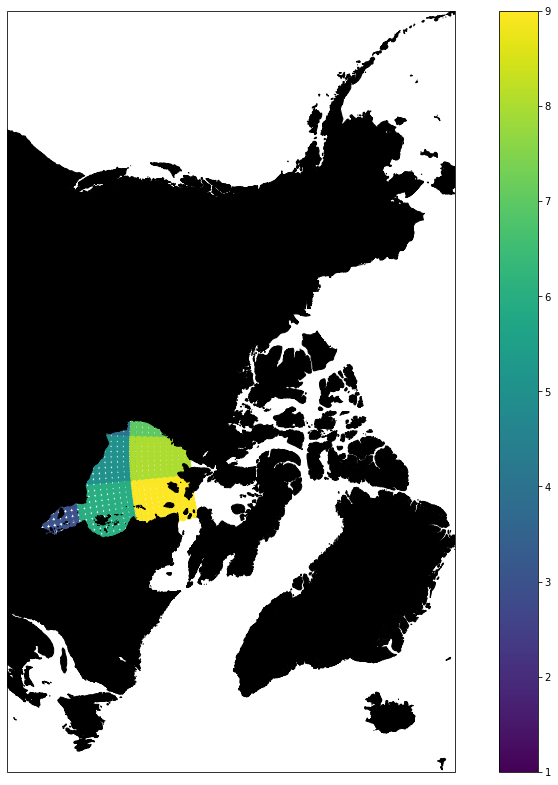

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
# cbarlabel='Difference(March-Sept)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
cont1=ax1.scatter(lon,lat,c=param,transform=ccrs.PlateCarree(),cmap='viridis',marker='o',vmin=1,vmax=9)
cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
# cbar.set_label(cbarlabel, rotation=90, fontsize=18)
# cbar.ax.tick_params(labelsize=18)
plt.show()

plot HS polygon on map and tg. 

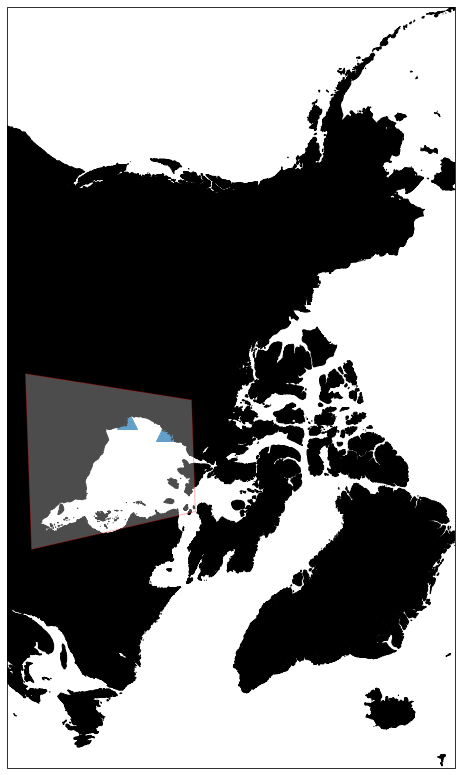

In [179]:
tg2pos=np.array([[-94.204,58.784],[-92.548,62.1533]])
tgname=np.array(['Churchill','Whalecove'])
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
# cbarlabel='Difference(March-Sept)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
ax1.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor='white', edgecolor='red', alpha=0.3)

ax1.scatter(tg2pos[:,0],tg2pos[:,1],transform=ccrs.PlateCarree(),marker='^',s=400)
plt.show()

Here we check the output which is optimized versus the initial versus observed just for the test model

In [102]:
#initial model run data.
runfolder='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_runs/snellius_runs/OpenDAruns/basic_test_model/'
inifile=runfolder+'work2/output/canada_model_0000_his.nc'
optfile=runfolder+'work11/output/canada_model_0000_his.nc'


In [130]:
#checking the his file output

inidata=xr.open_dataset(inifile)
optdata=xr.open_dataset(optfile)

In [131]:
hmod=inidata.waterlevel[1:,:]
hmod2=optdata.waterlevel[1:,:]
time=inidata.time[1:]


In [156]:
# tgfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/basic_test_model/stochObserver/churchill_jan.wl'
tgfile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/basic_test_model/stochObserver/whalecove_jan.wl'
hdata=np.array(np.loadtxt(tgfile,skiprows=2,usecols=1))
hdatameanred=hdata-np.mean(hdata)

In [158]:
i=1
tg='Whalecove'


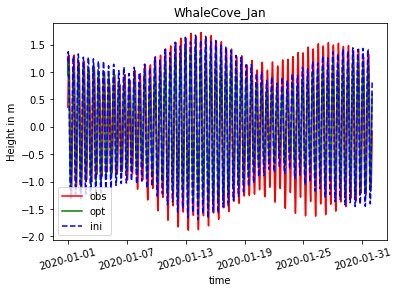

In [160]:
fig=plt.figure()
plt.plot(time,hdatameanred,label='obs',color='r')
plt.plot(time,hmod2[:,i],color='g',label='opt')
plt.plot(time,hmod[:,i],'--',color='blue',label='ini')
plt.xlabel('time')
labels=np.array(time)[::96*6]
labels=[str(labels[i])[:10] for i in range(len(labels))]
plt.xticks(labels,labels,rotation='15')
plt.ylabel('Height in m')
plt.legend()
plt.title('WhaleCove_Jan')
plt.savefig(tg+'.jpg')

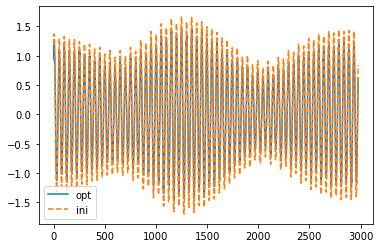

In [161]:
plt.plot(hmod2[:,i],label='opt')
plt.plot(hmod[:,i],'--',label='ini')
plt.legend()

P

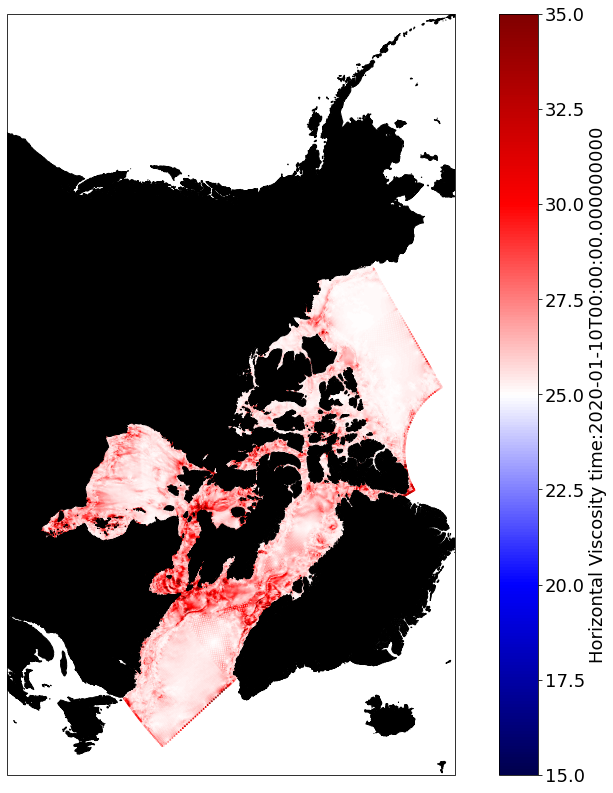

In [18]:

# plt.scatter(mapdata.FlowLink_xu,mapdata.FlowLink_yu,c=arr)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf 
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
# FFWriter=animation.FFMpegWriter(extra_args=['-vcodec', 'libx264'])
# def update(i):
#     i=int(i)
#     arr=mapdata.viu.values[i,:]
#     cont1=ax1.scatter(mapdata.FlowLink_xu,mapdata.FlowLink_yu,c=arr,transform=ccrs.PlateCarree(),cmap='seismic',marker='^',s=1,vmin=0,vmax=100)
#     return cont1,   
# # marking the x-axis and y-axis 
# def init():
#     ax.set_xlim(0, 2*np.pi)
#     ax.set_ylim(-1, 1)
#     return ln,
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
i=-1
arr=mapdata.viu.values[i,:]
cont1=ax1.scatter(mapdata.FlowLink_xu,mapdata.FlowLink_yu,c=arr,transform=ccrs.PlateCarree(),cmap='seismic',marker='^',s=1,vmin=15,vmax=35)
ti=mapdata.time[i]
cbarlabel='Horizontal Viscosity time:'+str(ti.values) 
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
# ani=FuncAnimation(fig,update,frames=np.linspace(0,96,97),blit=True)
cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=18)
# ani.save('vismovie.mp4',writer=FFWriter)
# plt.show()
plt.savefig('Horizontal_vis_'+str(ti.values)+'.jpg',dpi=200)

In [4]:
#shear and bulk viscosities of sea ice EVP and shiming yu ppt
P_s=25.
h=1.
C=20.
A=0.9
H=300
deltao=2e-09
e=2.
rhoi=920.
P=P_s*h*np.exp(-C*(1-A))
zeta=P/(2*deltao)
etai=zeta/e**2
etam=etai/(H*rhoi)
print(etam)
# print(zeta)

766.1644204971284


now we get xml files for bf and depth parameter file.s


In [4]:
bfparams=17
bathyparams=21 
visparams=4
ficeparams=3
#for combined.
Nparams=bfparams+bathyparams+visparams+ficeparams


In [7]:
def editregconst(root,idstr,i,covval):
    if idstr=='bf_':
        paraid=idstr+str(i+1)
    elif idstr=='depth_':
        paraid=idstr+str(i-16)
    elif idstr=='vis_':
        paraid=idstr+str(i-37)
    else:
        paraid=idstr+str(i-41)
    attrib1={}
    ET.SubElement(root[1][0],'regularisationConstant',attrib1)
    attrib1={'transformation':"identity",'value':covval}
    ET.SubElement(root[1][0][i],'stdDev',attrib1)
    #subelem2
    attrib2={'id':paraid}
    ET.SubElement(root[1][0][i],'vector',attrib2)

In [8]:
stochmodfloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/Canadamodel_sept_1/stochModel/'
stochmodfile=stochmodfloc+'StochModel_template.xml'
# newxmlfile=newtgfileloc+'noosObsfile.xml'
# shutil.copy2(tempxmlfile,newxmlfile)
tree=ET.parse(stochmodfile)
root=tree.getroot()
for elem in root[1][0]:
    print(elem)
    print(elem.attrib)
    print(elem.text)

root[1][0].remove(root[1][0][0])
for i in range(Nparams):
    if i<17:
        idstr='bf_'
        covval="0.2"
        editregconst(root,idstr,i,covval)
    elif 17<=i<38:
        print(i)
        idstr='depth_'
        covval="0.05"
        editregconst(root,idstr,i,covval)
    elif 38<=i<42:
        idstr='vis_'
        covval="2.0"
        editregconst(root,idstr,i,covval)
    else:
        idstr='fice_'
        covval="0.2"
        editregconst(root,idstr,i,covval)
root[1][1].remove(root[1][1][0])
for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]    #[1:-1]
    atgname=tgname+'_'+month+'.waterlevel'
    attrib1={'id':atgname}
    ET.SubElement(root[1][1],'vector',attrib1)

ET.register_namespace("", "http://www.openda.org")
tree.write(stochmodfloc+'stochModel.xml')

<Element '{http://www.openda.org}regularisationConstant' at 0x7f673c389e00>
{}

                
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


Now the same thing above but with viscosity and fastice.


In [15]:
def editregconst(root,idstr,i,covval):
    if idstr=='fice_':
        paraid=idstr+str(i+1)
    else:
        paraid=idstr+str(i-19)
    attrib1={}
    ET.SubElement(root[1][0],'regularisationConstant',attrib1)
    attrib1={'transformation':"identity",'value':covval}
    ET.SubElement(root[1][0][i],'stdDev',attrib1)
    #subelem2
    attrib2={'id':paraid}
    ET.SubElement(root[1][0][i],'vector',attrib2)

In [16]:
ficeparams=20
visparams=22 
Nparams=ficeparams+visparams
#for combined.
stochmodfloc='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/Canadamodel_march_1/stochModel/'
stochmodfile=stochmodfloc+'StochModel_template.xml'
# newxmlfile=newtgfileloc+'noosObsfile.xml'
# shutil.copy2(tempxmlfile,newxmlfile)
tree=ET.parse(stochmodfile)
root=tree.getroot()
for elem in root[1][0]:
    print(elem)
    print(elem.attrib)
    print(elem.text)

root[1][0].remove(root[1][0][0])
for i in range(Nparams):
    if i<20:
        idstr='fice_'
        covval="0.2"
        editregconst(root,idstr,i,covval)
    else:
        idstr='vis_'
        covval="2.0"
        editregconst(root,idstr,i,covval)
root[1][1].remove(root[1][1][0])
for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]    #[1:-1]
    atgname=tgname+'_'+month+'.waterlevel'
    attrib1={'id':atgname}
    ET.SubElement(root[1][1],'vector',attrib1)

ET.register_namespace("", "http://www.openda.org")
tree.write(stochmodfloc+'stochModel.xml')

<Element '{http://www.openda.org}regularisationConstant' at 0x7f98ab1523b0>
{}

                


Next is the model file with obs and parameter.

In [9]:
obsparafile=stochmodfloc+'ObsPara_template.xml'
# obsparafile=stochmodfloc+'Model_depth_17.xml'

tree=ET.parse(obsparafile)
root=tree.getroot()

print(root[3][2])
root[3].remove(root[3][2])
for i in range(len(selTGnam))[:]:
    tgname=selTGnam[i]    #[1:-1]
    atgname=tgname+'_'+month+'.waterlevel'
    attrib1={'id':atgname,'elementId':atgname,'ioObjectId':"%netcdfoutput%"}
    ET.SubElement(root[3],'vector',attrib1)

ET.register_namespace("", "http://www.openda.org")
tree.write(stochmodfloc+'Model_17bf_21depth_4vis_3fice.xml.xml')

<Element '{http://www.openda.org}vector' at 0x7f673c3dccc0>
